In [244]:
import pandas as pd
import numpy as np
from pdb import set_trace

In [285]:
def winProbability(eloA, eloB) :
    diff = eloA - eloB
    p = 1 - 1 / (1 + 10 ** (diff / 400.0))
    return(p)

def rate_1vs1(p1, p2, mov=1, week=8):
    #k = .06 * (w - 17)**2 + 20
    k = 20
    k_multiplier = np.log(abs(mov) + 1)
    #if mov < 0:
    #    k_multiplier *= -1
    corr_m = 2.2 / ((p1 - p2)*.001 + 2.2)
    rp1 = 10 ** (p1/400)
    rp2 = 10 ** (p2/400)
    exp_p1 = rp1 /(rp1 + rp2)
    exp_p2 = rp2 /(rp1 + rp2)
    if (mov == 0):
        s1 = 0.5
        s2 = 0.5
    elif(mov > 0):
        s1 = 1
        s2 = 0
    else:
        s1 = 0
        s2 = 1
    new_p1 = p1 + k_multiplier * corr_m * k * (s1 - exp_p1)
    new_p2 = p2 + k_multiplier * corr_m * k * (s2 - exp_p2)
    return new_p1, new_p2
                                        
                                        


In [246]:
df = pd.read_csv("allSeasonScores.csv")
eloDict = dict()

# find average difference between Opoints and DPoints


avgPointsDict = dict()
for y in range(1999,2020):
    currSeason = df[df.season == y]
    HOPoints = np.array(currSeason.homeOffPoints)
    AOPoints = np.array(currSeason.awayOffPoints)
    HDPoints = np.array(currSeason.homeDefPoints)
    ADPoints = np.array(currSeason.awayDefPoints)
    homeMOV = np.mean(HOPoints - ADPoints)
    awayMOV = np.mean(AOPoints - HDPoints)
    avgPointsDict[y] = {'home' : homeMOV, 'away' : awayMOV}

In [247]:
'''
for team in set(df.homeTeam):
    eloDict[team] = dict()
    for y in range(1999,2020):
        eloDict[team][y] = dict()
        for w in range(0,18):
            eloDict[team][y][w] = dict()
            for unit in ['off', 'def']:
                eloDict[team][y][w][unit] = 10000000000000
'''
    
    #unit = {'off' : 1500, 'def' : 1500}
    #weekDict = {0: unit}
    #seasonDict = {1999: weekDict}
    #eloDict[team] = seasonDict

"\nfor team in set(df.homeTeam):\n    eloDict[team] = dict()\n    for y in range(1999,2020):\n        eloDict[team][y] = dict()\n        for w in range(0,18):\n            eloDict[team][y][w] = dict()\n            for unit in ['off', 'def']:\n                eloDict[team][y][w][unit] = 10000000000000\n"

In [248]:
def getMostRecentElo(team, unit):
    try: 
        season = eloDict[team][max(eloDict[team].keys())]
        result =  season[max(season.keys())][unit]
        #print(result)
        return result
    except:
        return 1500
    
    
def setDict(team, year, week):
    if eloDict[team] == None:
        eloDict[team] = dict()
    elif eloDict[team][year] == None:
        eloDict[team][year] = dict()
    elif eloDict[team][year][week] == None:
        eloDict[team][year][week] = dict()

In [289]:
maxO = 1500
minO = 1500
maxD = 1500
minD = 1500


offenseRatingsList = list()
defenseRatingsList = list()
eloDict = dict()
for index, row in df.iterrows():
    
    homeTeam = row.homeTeam
    awayTeam = row.awayTeam
    HomeOffDiff = row.homeOffPoints - row.awayDefPoints
    AwayOffDiff = row.awayOffPoints - row.homeDefPoints
    y = row.season
    w = row.week
    
    
    if homeTeam not in eloDict.keys():
        eloDict[homeTeam] = dict()
    if y not in eloDict[homeTeam].keys():
        eloDict[homeTeam][y] = {0 : {'off' : ((getMostRecentElo(homeTeam, 'off') - 1500) * 1/3) + 1500, 
                                     'def': ((getMostRecentElo(homeTeam, 'def') - 1500) * 1/3) + 1500}}
        
    if awayTeam not in eloDict.keys():
        eloDict[awayTeam] = dict()
    if y not in eloDict[awayTeam].keys():
        eloDict[awayTeam][y] = {0 : {'off' : ((getMostRecentElo(awayTeam, 'off') - 1500) * 1/3) + 1500, 
                                     'def': ((getMostRecentElo(awayTeam, 'def') - 1500) * 1/3) + 1500}}
    
    avgHomeMOV = avgPointsDict[y]['home']
    avgAwayMOV = avgPointsDict[y]['away']
    HOELO = getMostRecentElo(homeTeam, 'off')
    ADELO = getMostRecentElo(awayTeam, 'def')
    AOELO = getMostRecentElo(awayTeam, 'off')
    HDELO = getMostRecentElo(homeTeam, 'def')
    
    
    a, b = rate_1vs1(HOELO, ADELO, HomeOffDiff - avgHomeMOV, w)
    
   

    eloDict[awayTeam][y][w] = dict()
    eloDict[homeTeam][y][w] = dict()
    
    eloDict[homeTeam][y][w]['off'] = a
    eloDict[awayTeam][y][w]['def'] = b
        

    c, d = rate_1vs1(AOELO, HDELO, AwayOffDiff - avgAwayMOV, w)
    eloDict[awayTeam][y][w]['off'] = c
    eloDict[homeTeam][y][w]['def'] = d
    
    offenseRatingsList.append(a)
    offenseRatingsList.append(c)
    defenseRatingsList.append(b)
    defenseRatingsList.append(d)
    # ((homeTeam == 'BAL') or (awayTeam == 'BAL'))
    # ((HomeOffDiff - avgHomeMOV < 0) or (AwayOffDiff - avgAwayMOV < 0))
    if ((y == 2011) & ((homeTeam == 'LA') or (awayTeam == 'LA'))):
        if ((homeTeam == 'LA') & (HomeOffDiff - avgHomeMOV > 0)):
            #set_trace()
            spomeVar = 69
        elif ((awayTeam == 'LA') & (AwayOffDiff - avgAwayMOV > 0)):
              #set_trace()
                someVar = 69
        someVar = 69
    
    
    maxO = max(maxO, a, c)
    minO = min(minO, a, c)
    maxD = max(maxD, b, d)
    minD = min(minD, b, d)

In [290]:
eloDict

{'PHI': {1999: {0: {'off': 1500.0, 'def': 1500.0},
   1: {'off': 1517.7130885875677, 'def': 1476.2142900002802},
   2: {'off': 1489.9196948951412, 'def': 1460.1983759519478},
   3: {'def': 1439.898510027168, 'off': 1462.7763776619029},
   4: {'def': 1464.2538792324299, 'off': 1441.4981300351908},
   5: {'off': 1426.218882887313, 'def': 1487.0099380331455},
   6: {'def': 1500.1828097386435, 'off': 1448.2630845789292},
   7: {'def': 1525.8902007564147, 'off': 1429.0200291055444},
   8: {'off': 1414.7549673211797, 'def': 1517.8971084750049},
   9: {'def': 1491.6635655590917, 'off': 1394.3921376298129},
   10: {'off': 1425.1600437505947, 'def': 1475.2213263997166},
   11: {'off': 1406.9428404188461, 'def': 1460.0022582873582},
   12: {'def': 1456.474833660472, 'off': 1413.1985663594278},
   13: {'def': 1471.8381664227566, 'off': 1399.2839320345636},
   14: {'def': 1465.5934653141846, 'off': 1389.016387519467},
   15: {'off': 1413.7813524727183, 'def': 1488.1452465864515},
   17: {'off': 14

In [302]:
# write the dictionary to a json file


import json

with open('eloVals.json', 'w') as fp:
    json.dump(eloDict, fp, sort_keys=True, indent=4)

In [182]:
with open('eloVals.json', 'r') as fp:
    testLoad = json.load(fp)

In [183]:
type(testLoad)

dict

In [ ]:

# team is the team abbreviation (ARI, ATL, BAL, etc)
# year is the season. Note that if we are talking about the 2018-19 season, year would be 2018
# week is which week we are looking for the ELO rating in.
#     *** NOTE *** this function assumes that you are attempting to find the ELO at the start of a week, meaning
#                  that if you passed 'week = 1' it would be the teams rating BEFORE the game was played. 
#                  this explains why it is '...[week - 1]...' in the 'try' part of the below function
# unit is either 'off' (offense) or 'def' (defense)
# data is the dictionary object
def getInitialEloRating(team, year, week, unit, data = eloDict):
    try:
        return data[team][year][week - 1][unit]
    except:
        # What if we are missing that week? For instance, the bucs dolphins game in 2017 week 1 was postponed
        # until week 11 because of a hurricane. So if you tried something like...
        # data['MIA'][2017][2]['off'] you would get an error...
        # the solution to this problem is that we are going to try and find the most recent ELO ratings.
        # it is guaranteed that for each team, for each season, there exists their week 0, or initial, elo ratings which
        # are based on their ending values from the prevrious season. So in the example above (bucs dolphins) we would end
        # up with the initial rank at week 0.
        season = data[team][year]
        
        # descending order...
        for w in range(week - 1,-1, -1):
            try:
                return season[w][unit]
            except:
                pass

In [189]:
df2 = pd.DataFrame.from_dict(testLoad)

In [291]:
forPlot = pd.DataFrame({'Offense' : offenseRatingsList, "Defense" : defenseRatingsList})

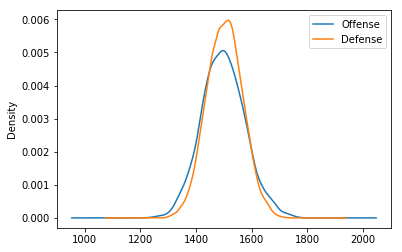

In [292]:
p = forPlot.plot.kde()

In [208]:
avgPointsDict

{1999: {'home': 19.12145748987854, 'away': 16.210526315789473},
 2000: {'home': 19.58130081300813, 'away': 16.9390243902439},
 2001: {'home': 18.177419354838708, 'away': 16.193548387096776},
 2002: {'home': 20.12890625, 'away': 17.9296875},
 2003: {'home': 19.91015625, 'away': 16.40234375},
 2004: {'home': 19.859375, 'away': 17.41796875},
 2005: {'home': 20.1171875, 'away': 16.45703125},
 2006: {'home': 18.37890625, 'away': 17.65234375},
 2007: {'home': 20.13671875, 'away': 17.31640625},
 2008: {'home': 20.34375, 'away': 17.83203125},
 2009: {'home': 20.203125, 'away': 17.99609375},
 2010: {'home': 20.375, 'away': 18.4609375},
 2011: {'home': 20.9375, 'away': 17.73046875},
 2012: {'home': 20.61328125, 'away': 18.2734375},
 2013: {'home': 21.734375, 'away': 18.73046875},
 2014: {'home': 21.08984375, 'away': 18.67578125},
 2015: {'home': 20.9140625, 'away': 19.375},
 2016: {'home': 22.23046875, 'away': 19.640625},
 2017: {'home': 20.52734375, 'away': 18.0859375},
 2018: {'home': 22.42187

In [235]:
eloDict['BAL'][2000]

{0: {'off': 1626.2965839224435, 'def': 1621.6418527120602},
 1: {'def': 1595.8208042274052, 'off': 1646.652570943877},
 2: {'off': 1670.2787603995016, 'def': 1579.1754335393468},
 3: {'def': 1577.0712248793463, 'off': 1735.3884796381521},
 4: {'off': 1808.373831588145, 'def': 1564.335151751231},
 5: {'def': 1555.1904493217821, 'off': 1858.882882596336},
 6: {'def': 1549.3251495340578, 'off': 1861.240917350724},
 7: {'def': 1533.209650391614, 'off': 1936.2632130820339},
 8: {'off': 1941.9417667463333, 'def': 1528.059421091785},
 9: {'off': 1980.0447840926624, 'def': 1522.6570355196457},
 10: {'def': 1519.3357817672854, 'off': 2007.2305200251633},
 11: {'def': 1517.696344187863, 'off': 2007.2927267230396},
 12: {'off': 2025.3566716845557, 'def': 1510.5817719006272},
 13: {'off': 2067.772157718723, 'def': 1508.4571721992472},
 15: {'off': 2068.3507067142496, 'def': 1506.1419724779737},
 16: {'def': 1504.615812125186, 'off': 2068.8983060508613},
 17: {'off': 2070.5493474377363, 'def': 1502

In [213]:
eloDict['BAL'][2000]

{0: {'off': 1489.8183413907325, 'def': 1517.6785855022815},
 1: {'def': 1575.2814606575469, 'off': 1488.2925699963782},
 2: {'off': 1549.0514023154492, 'def': 1449.7704950330851},
 3: {'def': 1444.4037279437096, 'off': 1460.620579163172},
 4: {'off': 1508.6590474977836, 'def': 1543.5067655931914},
 5: {'def': 1599.2525162632944, 'off': 1474.4882773782815},
 6: {'def': 1647.5906514004923, 'off': 1485.305801136734},
 7: {'def': 1693.5631664077548, 'off': 1464.8483006157105},
 8: {'off': 1419.4183683131744, 'def': 1529.7367441218962},
 9: {'off': 1374.7893581950518, 'def': 1524.6957415077363},
 10: {'def': 1559.626939485498, 'off': 1527.5672641366996},
 11: {'def': 1579.3679358366426, 'off': 1500.655812695005},
 12: {'off': 1525.6270971356284, 'def': 1531.0350185883747},
 13: {'off': 1561.3198159076335, 'def': 1525.0716877230468},
 15: {'off': 1573.4564699995562, 'def': 1527.3642459822315},
 16: {'def': 1557.814869833736, 'off': 1483.9804067669818},
 17: {'off': 1457.4564591191424, 'def':

In [293]:
maxD

1723.5114886241593

In [297]:
minD

1290.8820189844848

In [298]:
maxO

1773.365603249586

In [299]:
minO

1226.736460808153

In [300]:
np.mean(offenseRatingsList)

1497.808513520625

In [301]:
np.mean(defenseRatingsList)

1502.3493966860221